<a href="https://colab.research.google.com/github/kiyong21c/kaggle/blob/main/20220701_Aerial-Cactus-Identification-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 항공 사진 내 선인장 식별
 - 항공 사진 내 선인장이 있을 확률 예측
 - 문제유형 : 이진분류
 - 평가지표 : ROC AUC(1: 완벽히 예측)
 - 사용모델 : 기본 CNN
 - 훈련/테스트/샘플제출 데이터 이외 이미지 데이터(훈련/테스트)

## 탐색적 데이터 분석

In [9]:
import pandas as pd

data_path = '/content/drive/MyDrive/Colab Notebooks/kaggle/input/Aerial-Cactus-Identification/'

labels = pd.read_csv(data_path + 'train.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')

In [10]:
labels.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


 - id피처는 훈련 데이터 이미지 파일명
 - has_cactus는 타깃값

 - 해당 파일명을 가진 이미지가 선인장을 포함하는지 여부(0:선인장 없음, 1:있음)

In [11]:
submission.head()

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,0.5
1,0017242f54ececa4512b4d7937d1e21e.jpg,0.5
2,001ee6d8564003107853118ab87df407.jpg,0.5
3,002e175c3c1e060769475f52182583d0.jpg,0.5
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.5


 - id피처는 테스트 데이터 이미지 파일명
 - has_cactus는 의미 없음(예측해서 갱신 해줘야 함)

### 데이터 시각화
 - 타깃값만 활용해 그래프 rmfla

#### 타깃값 분포

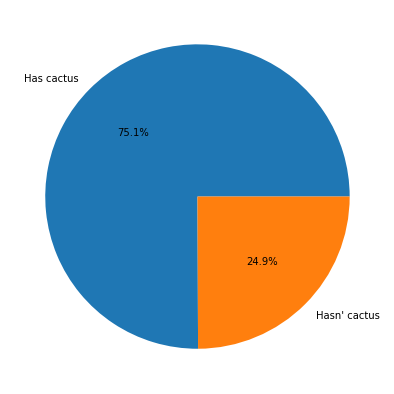

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))

label = ['Has cactus', 'Hasn\' cactus'] # '를 쓰기위한 탈출문자 \

plt.pie(labels['has_cactus'].value_counts(), labels=label, autopct='%.1f%%'); # ;붙이면 그래프만 나옴

#### 이미지 출력
 - 먼저 압축 파일 해제 : zipfile 모듈의 ZipFile클래스 사용

In [18]:
from zipfile import ZipFile

# 훈련 이미지 데이터 압축 풀기
with ZipFile(data_path + 'train.zip') as zipper:
    zipper.extractall() # zip파일이 있던 경로가 아닌 'content/train'에 압축이 해제됨

# 테스트 이미지 데이터 압축 풀기
with ZipFile(data_path + 'test.zip') as zipper:
    zipper.extractall() # zip파일이 있던 경로가 아닌 'content/test'에 압축이 해제됨

 - train, test 각각의 디렉토리에 이미지 파일이 몇개 들어있는지 확인

In [21]:
import os

num_train = len(os.listdir('/content/train/'))
num_test = len(os.listdir('/content/test/'))

print('훈련데이터 개수 : {}'.format(num_train))
print('테스트데이터 개수 : {}'.format(num_test))

훈련데이터 개수 : 17500
테스트데이터 개수 : 4000


 - 이제 훈련 이미지 데이터 몇 개 출력 : OpenCV 라이브러리

<Figure size 1080x432 with 0 Axes>

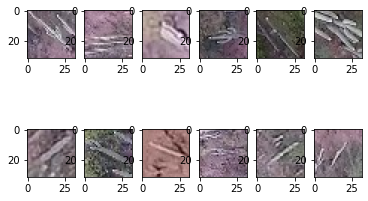

In [33]:
import matplotlib.pyplot as plt
import cv2

plt.figure(figsize=(15, 6))
fig, axes = plt.subplots(2, 6)

# 선인장을 포함하는 이미지 파일명(마지막 12개)
last_has_cactus_img_name = labels[labels['has_cactus']==1]['id'][-12:]

# 이미지 출력
for idx, img_name in enumerate(last_has_cactus_img_name):
    img_path = '/content/train/' + img_name
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    axes[idx//6][idx%6].imshow(image)   # subplots()를 통해 얻은 axes축의 인덱스 관리가 어려움(grid형태의 여러 축을 사용할 경우)

# 이제 왜 gridspec 쓰는지 알겠다
## grid를 설정하고 1차원 순서대로 할당 할 수 있어 편리함

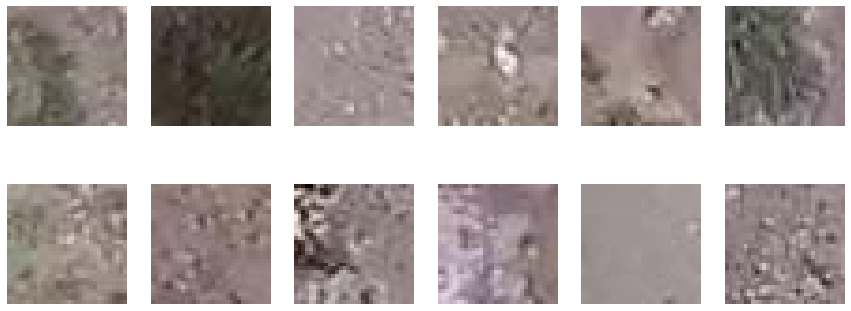

In [60]:
import matplotlib.gridspec as gridspec

plt.figure(figsize=(15, 6))
grid = gridspec.GridSpec(2, 6) # 격자 형태를 구성해놓고 grid[idx] 형태로 사용가능

# 선인장을 포함하지 않는 이미지 파일명(마지막 12개)
last_hasnt_cactus_img_name = labels[labels['has_cactus']==0]['id'][-12:]

# 이미지 출력
for idx, img_name in enumerate(last_hasnt_cactus_img_name):
    img_path = '/content/train/' + img_name
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(grid[idx])
    plt.axis('off') # 축 표시 제거
    plt.imshow(image)
    # ax.subplot(grid[idx]) # 축을 변수로 할당해줘도 됨
    # ax.imshow(image)


 - 그래프를 그리는 몇가지 방법

  > 1.plt.subplot(rows, cols)

  > 2.grid = gridspec.GridSpec(rows, cols)

  > plt.subplot(grid[idx])

  > 3.fig, axes = plt.subplots(rows, cols)
